# SQL Server

## Introduction

In this notebook, we will demonstrate the use of the SQL server workflow.
This workflow runs a server that provides access to an ApertureDB instance via queries in the SQL language, specifically the PostgreSQL dialect.

## Setup

In order to run this notebook, you will need to be running the SQL server workflow.
You can do this conveniently in the Cloud UI.

You will also need to have some data stored in your ApertureDB, perhaps from running the "Website Chatbot" or "Dataset Ingestion" workflows.

You will also need to know the password for the SQL server.
You can find that in the "Connection Helper" dialog in the Cloud UI.

In [2]:
import psycopg
from getpass import getpass
import os
import json
import pandas as pd
from aperturedb import NotebookHelpers as nh

## Enter Password

In [3]:
password = getpass("password")

## Set up the client connection

We're using the `psycipg` PostgreSQL database adaptor. 

In [ ]:
# If you are not runing this notebook in the ApertureDB Cloud, then you may need to set the host below.
host = "<DB-HOST>"
database = "aperturedb"
user = "aperturedb"

def run_query(query):
    """Run a query and return the results."""
    with psycopg.connect(
            f"dbname={database} user={user} password={password} host={host}") as conn:
        with conn.cursor() as cur:
            cur.execute(query)
            return pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

## Test the connection

If everything is set up correctly, this will print something like:
```
   ping
0	1
```

In [3]:
run_query("SELECT 1 AS ping")

NameError: name 'psycopg' is not defined

## List tables

Let's find out what tables the SQL server has.

Our tables are divided up into four schemata:
* `system`: This schema contains a table for every system object type, including one for `Entity` and one for `Connection`. These correspond to the `Find...` commands in the ApertureDB Query Language.
* `entity`: This schema contains a table for every user-defined entity class. These correspond to the values you can use with `with_class` in `FindEntity` commands.
* `connection`: This schema contains a table for every connection class (whether user-defined or system-defined). These correspond to the values you can use with `with_class` in `FindConnection` commands or the `connection_class` field in the `is_connected_to` parameter.
* `descriptor`: This schema contains a table for every descriptor set, effectively the values you can use with the `set` parameter in `FindDescriptor`.

Note that it isn't necessary to give the schema explicitly when referring to a table, unless the table name is ambiguous, because all four schemata are on the search path.
You will generally have to enclose table names in double quotes because their names are mixed case and can contain special characters, whereas unquoted identifiers in SQL are somewhat restricted.

In [11]:
def list_tables(schema):
    return run_query(f"""
        SELECT table_name
        FROM information_schema.tables
        WHERE table_schema = {schema!r}
        ORDER BY table_name;
        """)

for schema in ['system', 'entity', 'connection', 'descriptor']:
    tables = list_tables(schema)
    print(f"Tables in schema '{schema}' ({len(tables)} total):")
    display(tables)


Tables in schema 'system' (8 total):


,table_name
0,Blob
1,BoundingBox
2,Connection
3,Descriptor
4,DescriptorSet
5,Entity
6,Image
7,Polygon


Tables in schema 'entity' (9 total):


,table_name
0,CrawlDocument
1,CrawlRun
2,CrawlSpec
3,EmbeddingsRun
4,EmbeddingsSpec
5,FullText
6,Segment
7,SegmentationRun
8,SegmentationSpec


Tables in schema 'connection' (21 total):


,table_name
0,_BoundingBoxToImage
1,_DescriptorSetToDescriptor
2,_PolygonToImage
3,crawlDocumentHasBlob
4,crawlRunHasDocument
5,crawlSpecHasDocument
6,crawlSpecHasRun
7,crawlSpecHasSegmentationSpec
8,embeddingsRunHasDescriptor
9,embeddingsSpecHasDescriptor


Tables in schema 'descriptor' (2 total):


,table_name
0,ViT-B/16
1,crawl-to-rag


## Find some entities

Two ways to find entities. We can use the `system."Entity"` table to look at all entities, or a `entity.…` table to look at a specific entity type.

In [38]:
display(run_query("SELECT * FROM system.\"Entity\" LIMIT 5;"))

entity_class = list_tables(conn, 'entity').table_name[0]
print(f"Using entity class: {entity_class}")
display(run_query(f"SELECT * FROM entity.\"{entity_class}\" LIMIT 5;"))

,_uniqueid,cache_control,cache_control_max_age,content_type,crawl_time,domain,etag,expires,id,last_modified,...,total_tokens,type,uniqueid,_dimensions,_name,embeddings,embeddings_fingerprint,embeddings_model,embeddings_pretrained,embeddings_provider
0,7.0.540,None,NaN,None,NaT,None,None,NaT,None,NaT,...,None,None,None,None,None,None,None,None,None,None
1,8.0.560,None,NaN,None,NaT,None,None,NaT,None,NaT,...,None,None,None,None,None,None,None,None,None,None
2,10.0.16880,None,NaN,None,NaT,None,None,NaT,crawl-to-rag,NaT,...,None,None,None,None,None,None,None,None,None,None
3,11.0.16920,max-age=600,600.0,text/html; charset=utf-8,2025-08-04 15:05:35.429201+00:00,docs.aperturedata.io,"W/""688abc9f-53b3""",2025-08-04 14:10:44+00:00,c98928c3-4c53-482a-9bba-feddcc2ebc58,2025-07-31 00:45:19+00:00,...,None,None,None,None,None,None,None,None,None,None
4,11.1.16940,max-age=600,600.0,text/html; charset=utf-8,2025-08-04 15:05:37.209353+00:00,docs.aperturedata.io,"W/""688abc9f-87f7""",2025-08-04 15:15:35+00:00,7ed07ef2-a2e5-417e-ba86-968e635fa8c2,2025-07-31 00:45:19+00:00,...,None,None,None,None,None,None,None,None,None,None


Using entity class: CrawlDocument


,cache_control,cache_control_max_age,content_type,crawl_time,domain,etag,expires,id,last_modified,run_id,simple_content_type,spec_id,url,_uniqueid
0,max-age=600,600.0,text/html; charset=utf-8,2025-08-04 15:05:35.429201+00:00,docs.aperturedata.io,"W/""688abc9f-53b3""",2025-08-04 14:10:44+00:00,c98928c3-4c53-482a-9bba-feddcc2ebc58,2025-07-31 00:45:19+00:00,93f1c421-c58e-4409-8d0f-136c968326af,text/html,crawl-to-rag,https://docs.aperturedata.io/,11.0.16920
1,max-age=600,600.0,text/html; charset=utf-8,2025-08-04 15:05:37.209353+00:00,docs.aperturedata.io,"W/""688abc9f-87f7""",2025-08-04 15:15:35+00:00,7ed07ef2-a2e5-417e-ba86-968e635fa8c2,2025-07-31 00:45:19+00:00,93f1c421-c58e-4409-8d0f-136c968326af,text/html,crawl-to-rag,https://docs.aperturedata.io/administration/faq,11.1.16940
2,max-age=600,600.0,text/html; charset=utf-8,2025-08-04 15:05:37.637315+00:00,docs.aperturedata.io,"W/""688abc9f-16a0c""",2025-08-04 15:15:35+00:00,515b4e79-5eea-4247-bccf-451e823e5455,2025-07-31 00:45:19+00:00,93f1c421-c58e-4409-8d0f-136c968326af,text/html,crawl-to-rag,https://docs.aperturedata.io/Setup/QuickStart,11.2.16960
3,max-age=600,600.0,text/html; charset=utf-8,2025-08-04 15:05:37.663759+00:00,docs.aperturedata.io,"W/""688abc9f-5b5b""",2025-08-04 15:15:35+00:00,f3b2a374-16ae-410c-8e47-e9f275ad14ba,2025-07-31 00:45:19+00:00,93f1c421-c58e-4409-8d0f-136c968326af,text/html,crawl-to-rag,https://docs.aperturedata.io/category/command-...,11.3.16980
4,max-age=600,600.0,text/html; charset=utf-8,2025-08-04 15:05:37.664009+00:00,docs.aperturedata.io,"W/""688abc9f-561b""",2025-08-04 15:15:35+00:00,fe4de2a6-303d-4042-8000-38ac54d85749,2025-07-31 00:45:19+00:00,93f1c421-c58e-4409-8d0f-136c968326af,text/html,crawl-to-rag,https://docs.aperturedata.io/category/database...,11.4.17000


## Find some connections

We can do the same two types of query to find connections.
In the language of relational databases, you might like to think of ApertureDB connections as "join tables" or ["associative entities](https://en.wikipedia.org/wiki/Associative_entity)".

In [39]:
display(run_query("SELECT * FROM system.\"Connection\" LIMIT 5;"))

connection_class = list_tables(conn, 'connection').table_name[0]
print(f"Using connection class: {connection_class}")
display(run_query(f"SELECT * FROM connection.\"{connection_class}\" LIMIT 5;"))

,_uniqueid,_src,_dst
0,3.0.561,7.0.540,8.0.560
1,6.0.16921,10.0.16880,11.0.16920
2,6.1.16941,10.0.16880,11.1.16940
3,6.2.16961,10.0.16880,11.2.16960
4,6.3.16981,10.0.16880,11.3.16980


Using connection class: WorkflowCreated


,_uniqueid,_src,_dst
0,3.0.561,7.0.540,8.0.560
1,6.0.16921,10.0.16880,11.0.16920
2,6.1.16941,10.0.16880,11.1.16940
3,6.2.16961,10.0.16880,11.2.16960
4,6.3.16981,10.0.16880,11.3.16980


## Put it together: Graph query

One of the features of ApertureDB is that it acts as a graph database.
You can see this in SQL by joining tables together.


In [7]:
display(run_query("""
SELECT A.*, B.*, C.* FROM entity.\"CrawlRun\" AS A
INNER JOIN connection.\"crawlRunHasDocument\" AS B ON A._uniqueid = B._src
INNER JOIN entity.\"CrawlDocument\" AS C ON B._dst = C._uniqueid
LIMIT 5;
"""))

,content_type/text/html,downloader/request_bytes,downloader/request_count,downloader/request_method_count/GET,downloader/response_bytes,downloader/response_count,downloader/response_status_count/200,downloader/response_status_count/301,downloader/response_status_count/404,dupefilter/filtered,...,domain,etag,expires,id,last_modified,run_id,simple_content_type,spec_id,url,_uniqueid
0,286.0,108733.0,322.0,322.0,9752042.0,322.0,310.0,5.0,7.0,11353.0,...,docs.aperturedata.io,"W/""688abc9f-53b3""",2025-08-04 01:13:48+00:00,c80b962c-ffec-42b0-853e-9d4bf1f43c34,2025-07-31 00:45:19+00:00,84f20c48-0b39-4734-add1-955251e5d0f3,text/html,crawl-to-rag,https://docs.aperturedata.io/,8.0.160
1,286.0,108733.0,322.0,322.0,9752042.0,322.0,310.0,5.0,7.0,11353.0,...,docs.aperturedata.io,"W/""688abc9f-c0cb""",2025-08-04 01:13:49+00:00,d478d3ca-64c8-43c2-9466-4c1355ca7638,2025-07-31 00:45:19+00:00,84f20c48-0b39-4734-add1-955251e5d0f3,text/html,crawl-to-rag,https://docs.aperturedata.io/administration/tr...,8.1.180
2,286.0,108733.0,322.0,322.0,9752042.0,322.0,310.0,5.0,7.0,11353.0,...,docs.aperturedata.io,"W/""688abc9f-561b""",2025-08-04 01:13:49+00:00,ba5388e6-3bac-4638-9dfd-97db6f3b883d,2025-07-31 00:45:19+00:00,84f20c48-0b39-4734-add1-955251e5d0f3,text/html,crawl-to-rag,https://docs.aperturedata.io/category/database...,8.2.200
3,286.0,108733.0,322.0,322.0,9752042.0,322.0,310.0,5.0,7.0,11353.0,...,docs.aperturedata.io,"W/""688abc9f-16a0c""",2025-08-04 01:13:49+00:00,ba1cda19-6bee-4fa5-b7ae-f8091ce04964,2025-07-31 00:45:19+00:00,84f20c48-0b39-4734-add1-955251e5d0f3,text/html,crawl-to-rag,https://docs.aperturedata.io/Setup/QuickStart,8.3.220
4,286.0,108733.0,322.0,322.0,9752042.0,322.0,310.0,5.0,7.0,11353.0,...,docs.aperturedata.io,"W/""688abc9f-87f7""",2025-08-04 01:13:49+00:00,2902a0e7-1a19-4162-bd20-d61fda8ec4b5,2025-07-31 00:45:19+00:00,84f20c48-0b39-4734-add1-955251e5d0f3,text/html,crawl-to-rag,https://docs.aperturedata.io/administration/faq,8.4.240


## Look under the covers

So we know that these SQL queries are somehow being turned into ApertureDB Query Language queries under the covers.
Is there any way to see the actual AQL queries?
Yes, by using the EXPLAIN feature of SQL.

You should be able to find two `FindEntity`s and a `FindConnection`.

In [22]:
for row in run_query("""
    EXPLAIN
    SELECT A.*, B.*, C.* FROM entity.\"CrawlRun\" AS A
    INNER JOIN connection.\"crawlRunHasDocument\" AS B ON A._uniqueid = B._src
    INNER JOIN entity.\"CrawlDocument\" AS C ON B._dst = C._uniqueid
    LIMIT 5;
    """)['QUERY PLAN'].tolist():
    print(row)

Limit  (cost=60.00..248.83 rows=5 width=864)
  ->  Nested Loop  (cost=60.00..944141200930700525568.00 rows=25000000000000000000 width=864)
        Join Filter: (b._dst = c._uniqueid)
        ->  Nested Loop  (cost=40.00..550790700250000.00 rows=50000000000000 width=512)
              Join Filter: (a._uniqueid = b._src)
              ->  Foreign Scan on "CrawlRun" a  (cost=20.00..370000000000.00 rows=100000000 width=3700)
                    Multicorn: FDW: entity."CrawlRun"
                    Multicorn: AQL: [
  {
    "FindEntity": {
      "results": {
        "list": [
          "downloader/request_count"
          "httpcompression/response_count"
          "spider/response_status_count/200"
          "items_per_minute"
          "downloader/response_status_count/200"
          "responses_per_minute"
          "scheduler/enqueued"
          "downloader/request_bytes"
          "downloader/response_status_count/404"
          "memusage/max"
          "id"
          "item_scraped_count

## Find some images

In addition to being a graph database, ApertureDB is also a multi-modal object store.
This means that objects can have associated blobs, and ApertureDB can perform various operations on, say, images.

For objects that have an associated blob, such as images, we can fetch those blobs as part of the SQL query.
The blobs end up in a special field, here `_image` of type `BYTEA`.

It can be expensive to fetch blob data, and so ApertureDB never does so by default, only when [the `blobs` parameter](https://docs.aperturedata.io/query_language/Reference/shared_command_parameters/blobs) is set.
To ensure that blobs are not returned casually when the user asks for `SELECT *`, a special column `_blobs` must be set to ask for blobs.

Another special column here is `_operations`. In combination with SQL functions we have defined, we can generate a pipeline of [operations](https://docs.aperturedata.io/query_language/Reference/shared_command_parameters/operations) that mutate the blob.

A third special column here is `_as_format`, which lets you pick the format of the image blobs.

Finally, we can extract the actual blobs and display them. The transformations have made them pretty unrecognizable.

,adb_data_source,adb_image_height,adb_image_id,adb_image_sha256,adb_image_size,adb_image_width,aspect_ratio,coco_url,corpus,date_captured,...,license,seg_id,type,width,yfcc_id,_uniqueid,_blobs,_image,_as_format,_operations
0,coco,409.0,177714,a657517c647e12a9f1fa3d6ca70ef672e6692f8c83d054...,153475.0,640.0,1.564792,http://images.cocodataset.org/val2017/00000017...,val,2013-11-19 20:25:12+00:00,...,3.0,None,val,640.0,5.045822e+09,16.0.7060,True,b'\xff\xd8\xff\xfe\x00\x10Lavc60.31.102\x00\xf...,jpg,"[{'type': 'threshold', 'value': 128}, {'x': 10..."
1,coco,640.0,459887,91d4f983a969c27401423dcf207ce6982ddee5dd93a11a...,224163.0,480.0,0.750000,http://images.cocodataset.org/val2017/00000045...,val,2013-11-19 20:54:21+00:00,...,3.0,None,val,480.0,5.606991e+09,16.1.7060,True,b'\xff\xd8\xff\xe2\x0cXICC_PROFILE\x00\x01\x01...,jpg,"[{'type': 'threshold', 'value': 128}, {'x': 10..."
2,coco,468.0,155179,df0a53913e3fb3e4decf13aecb762fe0abe287f353d79a...,151729.0,640.0,1.367521,http://images.cocodataset.org/val2017/00000015...,val,2013-11-19 21:03:12+00:00,...,3.0,None,val,640.0,3.689865e+09,16.2.7060,True,b'\xff\xd8\xff\xfe\x00\x10Lavc60.31.102\x00\xf...,jpg,"[{'type': 'threshold', 'value': 128}, {'x': 10..."
3,coco,375.0,261116,8cfc85a1dcb5cffed839da9ecfa431ea148b5e14541b16...,137441.0,500.0,1.333333,http://images.cocodataset.org/val2017/00000026...,val,2013-11-19 21:09:38+00:00,...,1.0,None,val,500.0,6.860140e+08,16.3.7060,True,b'\xff\xd8\xff\xfe\x00\x10Lavc60.31.102\x00\xf...,jpg,"[{'type': 'threshold', 'value': 128}, {'x': 10..."
4,coco,480.0,396274,42b1b4b73603d0b5b089eacfa8a16bf5b3edbddca46b70...,299165.0,640.0,1.333333,http://images.cocodataset.org/val2017/00000039...,val,2013-11-19 21:40:14+00:00,...,3.0,None,val,640.0,4.934711e+09,16.4.7060,True,b'\xff\xd8\xff\xfe\x00\x10Lavc60.31.102\x00\xf...,jpg,"[{'type': 'threshold', 'value': 128}, {'x': 10..."


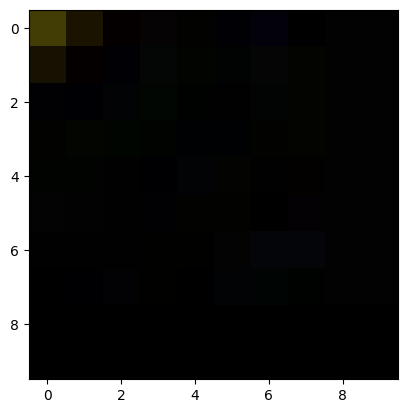

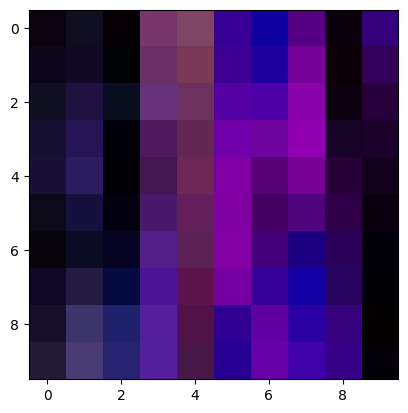

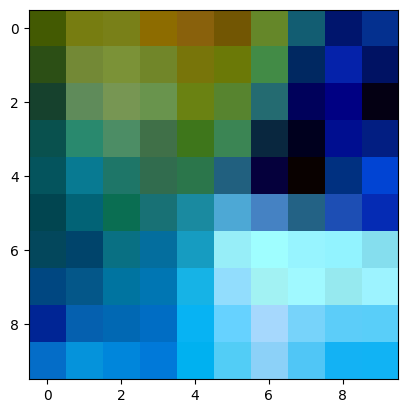

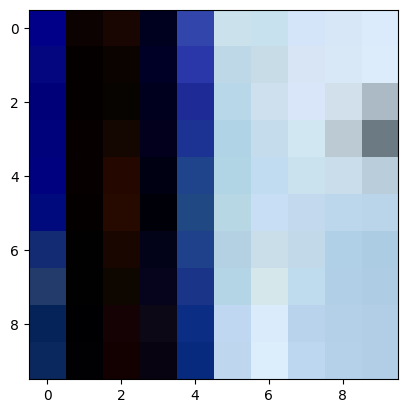

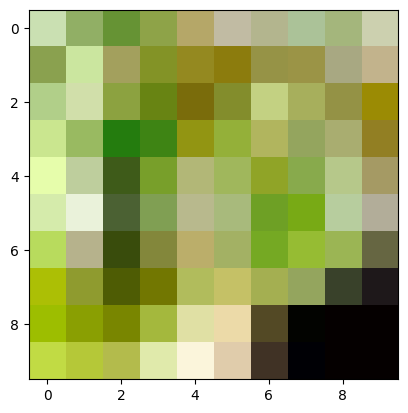

In [52]:
image_results = run_query("""
SELECT * FROM system."Image" 
WHERE _blobs
AND _operations = OPERATIONS(
	THRESHOLD(128), 
	CROP(x:=10, y:=10, width:=100, height:=100),
	FLIP(+1),
	ROTATE(angle:=90),
	RESIZE(width:=10))
AND _as_format = 'jpg'
LIMIT 5
""")
display(image_results)
blobs = image_results['_image'].tolist()
nh.display(blobs)

## Under the covers

That was a complicated SQL query.
What did that get transformed into in ApertureDB?
It turn out that the transformation is pretty direct.

You'll see the `blobs`, `as_format`, and `operations` parameters appearing in the `FindImage` command body.

In [23]:
for row in run_query("""
    EXPLAIN
    SELECT * FROM system."Image" 
    WHERE _blobs
    AND _operations = OPERATIONS(
        THRESHOLD(128), 
        CROP(x:=10, y:=10, width:=100, height:=100),
        FLIP(+1),
        ROTATE(angle:=90),
        RESIZE(width:=10))
    AND _as_format = 'jpg'
    LIMIT 5
    """)['QUERY PLAN'].tolist():
    print(row)


Limit  (cost=20.00..12020.00 rows=5 width=2400)
  ->  Foreign Scan on "Image"  (cost=20.00..240000000000.00 rows=100000000 width=2400)
        Filter: (_blobs AND (_operations = '[{"type": "threshold", "value": 128}, {"x": 10, "y": 10, "type": "crop", "width": 100, "height": 100}, {"code": 1, "type": "flip"}, {"type": "rotate", "angle": 90, "resize": false}, {"type": "resize", "width": 10}]'::jsonb) AND (_as_format = 'jpg'::text))
        Multicorn: FDW: system."Image"
        Multicorn: AQL: [
  {
    "FindImage": {
      "results": {
        "list": [
          "adb_image_sha256"
          "coco_url"
          "width"
          "adb_image_height"
          "flickr_url"
          "height"
          "date_captured"
          "_uniqueid"
          "aspect_ratio"
          "adb_image_width"
          "file_name"
          "adb_data_source"
          "type"
          "id"
          "license"
          "yfcc_id"
          "seg_id"
          "adb_image_size"
          "corpus"
          "ad

## Similarity search

In addition to being a graph database and an object store, ApertureDB is also a vector store.
We're going use this to find documents that are similar to an input text.

This example assumes that you have already run the "Website Chatbot" workflow.

In [5]:
text = "find entity"  # query text
similarity_results = run_query(f"""
SELECT * FROM descriptor."crawl-to-rag"
WHERE _find_similar = FIND_SIMILAR(
    text := {text!r},
    k := 10)
LIMIT 10
""")
display(similarity_results)


,_label,lc_url,run_id,segment_id,spec_id,text,title,uniqueid,url,_uniqueid,_find_similar,_distance,_blobs,_vector
0,None,https://docs.aperturedata.io/query_language/Ov...,0750b51d-5ce0-4f24-81ac-6b28ebc17174,08541241-1ceb-46c1-9dc3-635c886dab7e,crawl-to-rag,"sort the images by intelligence.Query:[{""FindE...",Handling of Missing Data | ApertureDB,0301cd8b-1e0e-4a6b-8c67-4ab3fafbb4dd,https://docs.aperturedata.io/query_language/Ov...,3.416.7040,"{'text': 'find entity', 'type': 'find_similar'...",0.656885,None,None
1,None,https://docs.aperturedata.io/query_language/Re...,0750b51d-5ce0-4f24-81ac-6b28ebc17174,6fe28295-5d54-4876-88d2-88c7b9961786,crawl-to-rag,"Here is an example:[{""FindEntity"":{""with_class...",constraints | ApertureDB,deb7e128-be7f-448e-9c64-ae8a0fdc430a,https://docs.aperturedata.io/query_language/Re...,3.577.7140,"{'text': 'find entity', 'type': 'find_similar'...",0.645904,None,None
2,None,https://docs.aperturedata.io/query_language/Re...,0750b51d-5ce0-4f24-81ac-6b28ebc17174,e93731f6-2404-4f47-99f9-81ae9d222df7,crawl-to-rag,"and update the ""year"" property:[{""FindEntity"":...",UpdateBlob | ApertureDB,5bfe5407-a851-4fa3-8a1e-8788c0dde136,https://docs.aperturedata.io/query_language/Re...,3.658.7180,"{'text': 'find entity', 'type': 'find_similar'...",0.638335,None,None
3,None,https://docs.aperturedata.io/HowToGuides/Advan...,0750b51d-5ce0-4f24-81ac-6b28ebc17174,428d17ab-f34f-4be8-bdb1-8f22c7de7526,crawl-to-rag,"={conf}\n"")converted=cv2.cvtColor(image,cv2.CO...",Image Classification with PyTorch and Aperture...,79a35db8-6935-41f5-90d8-848a96e3a7a3,https://docs.aperturedata.io/HowToGuides/Advan...,3.379.7020,"{'text': 'find entity', 'type': 'find_similar'...",0.637600,None,None
4,None,https://docs.aperturedata.io/query_language/Ov...,0750b51d-5ce0-4f24-81ac-6b28ebc17174,d9a02733-90c7-4817-a0e5-738c83ca6b3b,crawl-to-rag,"IQ property, the result will beQuery:[{""FindEn...",Handling of Missing Data | ApertureDB,53b444ae-669a-43f9-90e8-a44b3c88c6c4,https://docs.aperturedata.io/query_language/Ov...,3.417.7040,"{'text': 'find entity', 'type': 'find_similar'...",0.637298,None,None
5,None,https://docs.aperturedata.io/HowToGuides/start...,0750b51d-5ce0-4f24-81ac-6b28ebc17174,d8fceecf-890a-4452-b22a-a82c9bc7726b,crawl-to-rag,"""recipe_search"",""_uniqueid"": ""3.174639.224220""...",Work with Descriptors (Embeddings) | ApertureDB,07786227-52b9-484b-ad80-57fe8fd9b476,https://docs.aperturedata.io/HowToGuides/start...,3.371.7000,"{'text': 'find entity', 'type': 'find_similar'...",0.636487,None,None
6,None,https://docs.aperturedata.io/query_language/Re...,0750b51d-5ce0-4f24-81ac-6b28ebc17174,31675f4a-c74f-4a95-88f5-a58dc708304d,crawl-to-rag,"""unique_id"" property:[{""FindEntity"":{""_ref"":1,...",AddBoundingBox | ApertureDB,0e087b25-ee43-457c-86da-2c4cb0f10098,https://docs.aperturedata.io/query_language/Re...,3.756.7280,"{'text': 'find entity', 'type': 'find_similar'...",0.630308,None,None
7,None,https://docs.aperturedata.io/query_language/Ov...,0750b51d-5ce0-4f24-81ac-6b28ebc17174,460056ed-654b-4b9e-8c85-b0ddbcc32636,crawl-to-rag,entities. Let us first insert some entities:Qu...,Handling of Missing Data | ApertureDB,240f88bb-67d0-4f3d-a7b5-b7773778a4a6,https://docs.aperturedata.io/query_language/Ov...,3.415.7040,"{'text': 'find entity', 'type': 'find_similar'...",0.629380,None,None
8,None,https://docs.aperturedata.io/query_language/Re...,0750b51d-5ce0-4f24-81ac-6b28ebc17174,fbcbe95c-5ccf-40ba-ac1e-1f573efd8265,crawl-to-rag,"of them, the rest will be returned:[{""FindEnti...",Offset | ApertureDB,73502d09-0667-4023-b304-a2ac9ed280e8,https://docs.aperturedata.io/query_language/Re...,3.528.7130,"{'text': 'find entity', 'type': 'find_similar'...",0.628594,None,None
9,None,https://docs.aperturedata.io/query_language/Re...,0750b51d-5ce0-4f24-81ac-6b28ebc17174,7e4919e1-9801-4e69-a6e8-76d3f92aad22,crawl-to-rag,"and remove the ""label_type"" property:[{""FindIm...",UpdateBoundingBox | ApertureDB,b1d47697-b8f5-47bf-a4ed-61124592b36a,http

## Under the covers

This query is slightly different because the wrapper is performing the embedding for us.

In [6]:
for row in run_query(f"""
    EXPLAIN VERBOSE
    SELECT * FROM descriptor."crawl-to-rag"
    WHERE _find_similar = FIND_SIMILAR(
        text := {text!r},
        k := 10)
    LIMIT 10
    """)['QUERY PLAN'].tolist():
    print(row)

Limit  (cost=20.00..14020.00 rows=10 width=1400)
  Output: _label, lc_url, run_id, segment_id, spec_id, text, title, uniqueid, url, _uniqueid, _find_similar, _distance, _blobs, _vector
  ->  Foreign Scan on descriptor."crawl-to-rag"  (cost=20.00..140000000000.00 rows=100000000 width=1400)
        Output: _label, lc_url, run_id, segment_id, spec_id, text, title, uniqueid, url, _uniqueid, _find_similar, _distance, _blobs, _vector
        Filter: ("crawl-to-rag"._find_similar = '{"text": "find entity", "type": "find_similar", "image": null, "vector": null, "knn_first": true, "k_neighbors": 10}'::jsonb)
        Multicorn: FDW: descriptor."crawl-to-rag"
        Multicorn: AQL: [
  {
    "FindDescriptor": {
      "results": {
        "list": [
          "_uniqueid"
          "text"
          "uniqueid"
          "segment_id"
          "run_id"
          "lc_url"
          "url"
          "_label"
          "title"
          "spec_id"
          "_distance"
        ]
      }
      "set": "craw

An addition here (in `VERBOSE` mode) is that we have generated a query blob as can be seen in the last line.
Recall that the underlying ApertureDB interface receives two inputs: A JSON query and an optional list of binary blobs.
The query blobs are commonly used by commands like `AddImage` to upload data into ApertureDB.
`FindDescriptor` is special among `Find` commands because it can also take a query blob, representing the embedding of the query text or image.

Here the SQL wrapper knows the embedding model used to create this descriptor set, and is able to generate an embedding for the text supplied.
It will also do the same for images using `FIND_SIMILAR(IMAGE:=...)`.
It can also accept a plain vector as a JSON string.

## Conclusion

Here we have seen that the SQL Server Workflow can provide read-only access to a broad range of ApertureDB features, including graph queries, object retrieval and manipulation, and vector search.